### XGBoost model testing
Additional tests for XGBoost model - outputs duplicate dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import pickle
import time

%matplotlib inline
plt.style.use('seaborn-pastel')

import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from collections import defaultdict, Counter

%run evaluation_functions.py

In [2]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

Using TensorFlow backend.
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
with open("pickles/LR_model.pkl", "rb") as f:
    LR = pickle.load(f)
with open("pickles/RFC_model.pkl", "rb") as f:
    RFC = pickle.load(f)
with open("pickles/XGB_model.pkl", "rb") as f:
    XGB = pickle.load(f)
with open("pickles/LGB_model.pkl", "rb") as f:
    LGB = pickle.load(f)

In [4]:
with open("pickles/X_train.pickle", "rb") as f:
    X_train = pickle.load(f)
with open("pickles/y_train.pickle", "rb") as f:
    y_train = pickle.load(f)
with open("pickles/X_test.pickle", "rb") as f:
    X_test = pickle.load(f)
with open("pickles/y_test.pickle", "rb") as f:
    y_test = pickle.load(f)

In [5]:
X_cols = X_train.columns

### Feature importance

In [9]:
def Sort_Tuple(tup):  
  
    # reverse = None (Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1],reverse=True)  
    return tup   

In [10]:
#LR
a = list(zip(X_cols,LR.coef_[0]))
# for coef in Sort_Tuple(a):
#     print(coef)

In [11]:
#RFC
b = list(zip(X_cols,RFC.feature_importances_))
# for coef in Sort_Tuple(b):
#     print(coef)

In [35]:
#XGB
c = list(zip(X_cols,XGB.feature_importances_))
# for coef in Sort_Tuple(c):
#     print(coef)

In [54]:
#LGB
# d = list(zip(X_cols,LGB.feature_importances_))
# for coef in Sort_Tuple(d):
#     print(coef)

### XGB Feature Engineering

In [6]:
#drop columns that show zero feature importance: hypertension, diabetes, gender, handicap
with open('pickles/appt_v2_all0.pickle','rb') as read_file:
    appt_v4 = pickle.load(read_file)

In [7]:
feature_cols = ['Age2','Neighbourhood2','Scholarship','Alcoholism',
                'SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'Reschedule','Follow_up','prior_appt_count','prior_no_show_count']
a_Xv4 = appt_v4[feature_cols]
a_Xv4 = pd.get_dummies(a_Xv4, columns = ['Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
a_Xv4.drop(columns=['Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv4_cols = np.array(a_Xv4.columns)
# a_Xv4.info()

In [8]:
#appt_v4
Xv4, yv4 = a_Xv4, appt_v4['No_show_num']
Xv4_train, Xv4_test, yv4_train, yv4_test = train_test_split(Xv4, yv4, test_size = 0.25, random_state = 10, stratify = yv4)

In [9]:
def oversample(X_train,y_train):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
    X_resampled = pd.DataFrame(X_resampled,columns=X_train.columns)
    print(Counter(y_resampled))
    return X_resampled, y_resampled

In [10]:
Xv4_resampled, yv4_resampled = oversample(Xv4_train,yv4_train)

Counter({0: 38276, 1: 38276})


In [13]:
XGB3 = XGBClassifier(n_estimator=1000,max_depth=4,random_state=43)
XGB3.fit(Xv4_resampled,yv4_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimator=1000,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=43, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [44]:
# XGBoost - train
yv4_resampled_XGB_o = XGB3.predict(Xv4_resampled)
yv4_resampled_XGB_o_prob = XGB3.predict_proba(Xv4_resampled)[:,1]
print_scores(yv4_resampled,yv4_resampled_XGB_o)
print(f'XGB o - v4: {roc_auc_score(yv4_resampled, yv4_resampled_XGB_o_prob):.3f}') # XGB

Accuracy score: 0.6164437245271188
F1 score: 0.6100146101739939
Precision (true + / all predicted +): 0.6204138974442103
Recall (true + / all actual +): 0.5999581983488348
XGB o - v4: 0.666


In [45]:
#XGB - test
yv4_test_XGB_o = XGB3.predict(Xv4_test)
yv4_test_XGB_o_prob = XGB3.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_XGB_o)
print(f'XGB o - v4: {roc_auc_score(yv4_test, yv4_test_XGB_o_prob):.3f}') # RFC

Accuracy score: 0.6105334157720196
F1 score: 0.45125524669359307
Precision (true + / all predicted +): 0.37511520737327186
Recall (true + / all actual +): 0.5661764705882353
XGB o - v4: 0.633


In [48]:
#XGB
c = list(zip(Xv4_cols,XGB3.feature_importances_))
# for coef in Sort_Tuple(c):
#     print(coef)

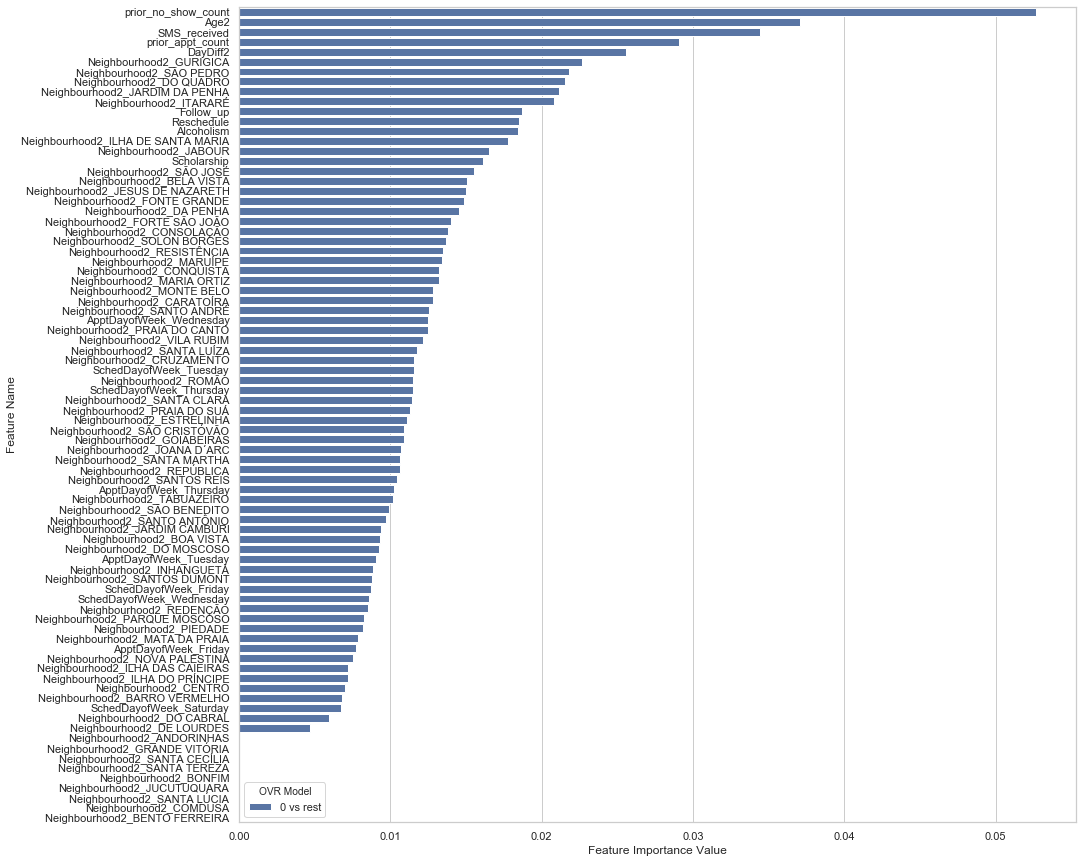

In [51]:
XGB3.feature_names = Xv4_cols
XGB3.target_names = XGB3.classes_
XGB3_df = plot_ovr_fi(XGB3)

In [25]:
kf = StratifiedKFold(n_splits=5,random_state=60,shuffle=True)

In [40]:
model = Pipeline([
        ('sampling', RandomOverSampler(random_state=42)),
        ('class', XGBClassifier(random_state=43))
    ])
grid_params = {'class__gamma':[5,10,15,20]}

In [41]:
XGB_GS=GridSearchCV(model,grid_params,cv=kf,n_jobs=-1,verbose=1,scoring='recall')
XGB_GS.fit(Xv4_resampled.values,yv4_resampled)
print(XGB_GS.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.4min finished


{'class__gamma': 5}


In [50]:
XGB4 = XGBClassifier(n_estimator=1000,max_depth=4,min_child_weight=0,gamma=5,random_state=43)
XGB4.fit(Xv4_resampled,yv4_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=0, missing=None, n_estimator=1000,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=43, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [51]:
# XGBoost - train
yv4_resampled_XGB_o = XGB4.predict(Xv4_resampled)
yv4_resampled_XGB_o_prob = XGB4.predict_proba(Xv4_resampled)[:,1]
print_scores(yv4_resampled,yv4_resampled_XGB_o)
print(f'XGB o - v4: {roc_auc_score(yv4_resampled, yv4_resampled_XGB_o_prob):.3f}') # XGB

Accuracy score: 0.6152549900721078
F1 score: 0.6079676290114338
Precision (true + / all predicted +): 0.6197053157137817
Recall (true + / all actual +): 0.5966663183195736
XGB o - v4: 0.665


In [52]:
#XGB - test
yv4_test_XGB_o = XGB4.predict(Xv4_test)
yv4_test_XGB_o_prob = XGB4.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_XGB_o)
print(f'XGB o - v4: {roc_auc_score(yv4_test, yv4_test_XGB_o_prob):.3f}') # RFC

Accuracy score: 0.6116575796751166
F1 score: 0.4508385660917256
Precision (true + / all predicted +): 0.3756788978672672
Recall (true + / all actual +): 0.5635930047694754
XGB o - v4: 0.633


In [26]:
# Test - Don't drop dummies
feature_cols = ['Age2','Neighbourhood2','Scholarship','Alcoholism',
                'SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'Reschedule','Follow_up','prior_appt_count','prior_no_show_count']
a_Xv5 = appt_v4[feature_cols]
a_Xv5 = pd.get_dummies(a_Xv5, columns = ['Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
# a_Xv4.drop(columns=['Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv5_cols = np.array(a_Xv5.columns)

In [30]:
#appt_v5
Xv5, yv5 = a_Xv5, appt_v4['No_show_num']
Xv5_train, Xv5_test, yv5_train, yv5_test = train_test_split(Xv5, yv5, test_size = 0.25, random_state = 10, stratify = yv5)

In [31]:
Xv5_resampled,yv5_resampled = oversample(Xv5_train,yv5_train)
Xv5_resampled.shape

Counter({0: 38276, 1: 38276})


(76552, 85)

In [32]:
XGB5 = XGBClassifier(n_estimator=1000,max_depth=4,random_state=43)
XGB5.fit(Xv5_resampled,yv5_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimator=1000,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=43, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [33]:
# XGBoost - train
yv5_resampled_XGB_o = XGB5.predict(Xv5_resampled)
yv5_resampled_XGB_o_prob = XGB5.predict_proba(Xv5_resampled)[:,1]
print_scores(yv5_resampled,yv5_resampled_XGB_o)
print(f'XGB o - v5: {roc_auc_score(yv5_resampled, yv5_resampled_XGB_o_prob):.3f}') # XGB

Accuracy score: 0.6173973246943254
F1 score: 0.6092559734247636
Precision (true + / all predicted +): 0.6225021128104469
Recall (true + / all actual +): 0.5965618141916605
XGB o - v5: 0.667


In [34]:
#XGB - test
yv5_test_XGB_o = XGB5.predict(Xv5_test)
yv5_test_XGB_o_prob = XGB5.predict_proba(Xv5_test)[:,1]
print_scores(yv5_test,yv5_test_XGB_o)
print(f'XGB o - v5: {roc_auc_score(yv5_test, yv5_test_XGB_o_prob):.3f}') # RFC

Accuracy score: 0.613456241920072
F1 score: 0.4504115719651562
Precision (true + / all predicted +): 0.3766876086084748
Recall (true + / all actual +): 0.5600158982511924
XGB o - v5: 0.633


In [56]:
## Save out v3 model
with open("pickles/XGB_model.pkl", "wb") as to_write:
    pickle.dump(XGB3, to_write)
    
with open('pickles/X2_train.pickle', 'wb') as to_write:
    pickle.dump(Xv4_resampled, to_write)
with open('pickles/y2_train.pickle', 'wb') as to_write:
    pickle.dump(yv4_resampled, to_write)
with open('pickles/X2_test.pickle', 'wb') as to_write:
    pickle.dump(Xv4_test, to_write)
with open('pickles/y2_test.pickle', 'wb') as to_write:
    pickle.dump(yv4_test, to_write)

### For flask

In [18]:
#XGB
# X_matrix = X_train.as_matrix()
# X_
XGB2 = XGBClassifier(n_estimator=1000,max_depth=4,random_state=43)
XGB2.fit(Xv4_resampled.values,yv4_resampled)
y_pred_XGB2 = XGB2.predict(Xv4_test.values)
y_pred_XGB2_prob = XGB2.predict_proba(Xv4_test.values)[:,1]
print_scores(yv4_test,y_pred_XGB2)
print(f'XGB o - v4: {roc_auc_score(yv4_test, y_pred_XGB2_prob):.3f}') # XGB

Accuracy score: 0.6105334157720196
F1 score: 0.45125524669359307
Precision (true + / all predicted +): 0.37511520737327186
Recall (true + / all actual +): 0.5661764705882353
XGB o - v4: 0.633


In [25]:
#for flask app
XGB2.feature_names = Xv4_train.columns
XGB2.target_names = ["Show","No-Show"]
with open("flask_app/static/models/appt_model.pkl", "wb") as f:
    pickle.dump(XGB2, f)

In [20]:
with open('flask_app/static/models/X_test.pickle', 'wb') as to_write:
    pickle.dump(Xv4_test, to_write)
with open('flask_app/static/models/y_test.pickle', 'wb') as to_write:
    pickle.dump(yv4_test, to_write)

In [16]:
neighborhood_names = appt_v4['Neighbourhood'].unique()

In [24]:
XGB2.neighborhood_names = neighborhood_names